# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

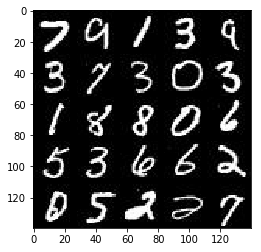

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

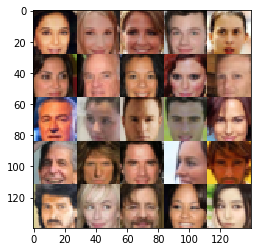

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # convert 28x28x(input_dimension) into 14x14x64
        layer1 = tf.layers.conv2d(images, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=keep_prob)
        #layer1 = tf.Print(layer1, [tf.shape(layer1)], "discriminator layer 1 shape", summarize=100)
        
        # convert 14x14x64 into 7x7x128
        layer2 = tf.layers.conv2d(layer1, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        #layer2 = tf.Print(layer2, [tf.shape(layer2)], "discriminator layer 2 shape", summarize=100)
        
        # convert 7x7x128 into 4x4x256
        layer3 = tf.layers.conv2d(layer2, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        #layer3 = tf.Print(layer3, [tf.shape(layer3)], "discriminator layer 3 shape", summarize=100)
        
        # flatten to linear array
        convolutions_output = tf.reshape(layer3, (-1, 4 * 4 * 256))
        
        logits = tf.layers.dense(convolutions_output, 1) # 1 single output
        output = tf.sigmoid(logits)
        
    return logits, output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):       
        # transform input into a tensor of 7x7x256
        layer1 = tf.layers.dense(z, 7 * 7 * 256)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=keep_prob)
        #layer1 = tf.Print(layer1, [tf.shape(layer1)], "generator layer 1 shape", summarize=100)
        
        # convert 7x7x256 into 14x14x128
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        #layer2 = tf.Print(layer2, [tf.shape(layer2)], "generator layer 2 shape", summarize=100)

        # convert 14x14x128 into 28x28x64
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        #layer3 = tf.Print(layer3, [tf.shape(layer3)], "generator layer 3 shape", summarize=100)

        # convert 28x28x64 into 28x28x(out_channel_dim)
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, 1, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        #layer4 = tf.Print(layer4, [tf.shape(layer4)], "generator layer 4 shape", summarize=100)
        output = tf.tanh(logits)
    
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_network = generator(input_z, out_channel_dim, is_train=True)
    
    discriminator_real_network, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_network, discriminator_fake_logits = discriminator(generator_network, reuse=True)
    
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_real_logits,
        labels=tf.ones_like(discriminator_real_network) * 0.9 # smooth real labels
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_fake_logits,
        labels=tf.zeros_like(discriminator_fake_network)
    ))
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_fake_logits,
        labels=tf.ones_like(discriminator_fake_network)
    ))
    
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss

    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_variables = tf.trainable_variables()
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    
    # choo chooo
    discriminator_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        generator_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
   
    return discriminator_train, generator_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, learning_rate_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels)
    
    discriminator_training, generator_training = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            iterations = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2.0 # normalize to -1, 1
                iterations += 1
                                
                batch_z_input = np.random.normal(0, scale=1.0, size=(batch_size, z_dim))
                #batch_z_input = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                network_feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z_input,
                    learning_rate_tensor: learning_rate
                }
                
                _ = sess.run(discriminator_training, feed_dict=network_feed_dict)
                _ = sess.run(generator_training, feed_dict=network_feed_dict)
                
                if iterations % 10 == 0:
                    training_loss_discriminator = discriminator_loss.eval(network_feed_dict)
                    training_loss_generator = generator_loss.eval(network_feed_dict)
                    
                    print("Iteration {:3} -- Epoch {}/{} -- Discriminator loss: {:5.5f} -- Generator loss: {:5.5f}".format(
                        iterations,
                        epoch_i + 1,
                        epoch_count,
                        training_loss_discriminator,
                        training_loss_generator
                    ))
                
                if iterations % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
        
        show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                    
    print("Done!")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Iteration  10 -- Epoch 1/2 -- Discriminator loss: 1.26040 -- Generator loss: 0.63240
Iteration  20 -- Epoch 1/2 -- Discriminator loss: 1.27277 -- Generator loss: 0.65002
Iteration  30 -- Epoch 1/2 -- Discriminator loss: 1.36177 -- Generator loss: 0.64251
Iteration  40 -- Epoch 1/2 -- Discriminator loss: 1.35548 -- Generator loss: 0.64138
Iteration  50 -- Epoch 1/2 -- Discriminator loss: 1.36151 -- Generator loss: 0.63912
Iteration  60 -- Epoch 1/2 -- Discriminator loss: 1.35802 -- Generator loss: 0.68016
Iteration  70 -- Epoch 1/2 -- Discriminator loss: 1.38468 -- Generator loss: 0.66785
Iteration  80 -- Epoch 1/2 -- Discriminator loss: 1.37611 -- Generator loss: 0.68841
Iteration  90 -- Epoch 1/2 -- Discriminator loss: 1.38431 -- Generator loss: 0.68286
Iteration 100 -- Epoch 1/2 -- Discriminator loss: 1.37583 -- Generator loss: 0.66407


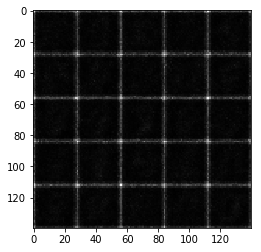

Iteration 110 -- Epoch 1/2 -- Discriminator loss: 1.36197 -- Generator loss: 0.67010
Iteration 120 -- Epoch 1/2 -- Discriminator loss: 1.37485 -- Generator loss: 0.65981
Iteration 130 -- Epoch 1/2 -- Discriminator loss: 1.36227 -- Generator loss: 0.65377
Iteration 140 -- Epoch 1/2 -- Discriminator loss: 1.36377 -- Generator loss: 0.65959
Iteration 150 -- Epoch 1/2 -- Discriminator loss: 1.38870 -- Generator loss: 0.64279
Iteration 160 -- Epoch 1/2 -- Discriminator loss: 1.38538 -- Generator loss: 0.68484
Iteration 170 -- Epoch 1/2 -- Discriminator loss: 1.36152 -- Generator loss: 0.60962
Iteration 180 -- Epoch 1/2 -- Discriminator loss: 1.34195 -- Generator loss: 0.65102
Iteration 190 -- Epoch 1/2 -- Discriminator loss: 1.37084 -- Generator loss: 0.67260
Iteration 200 -- Epoch 1/2 -- Discriminator loss: 1.36651 -- Generator loss: 0.67376


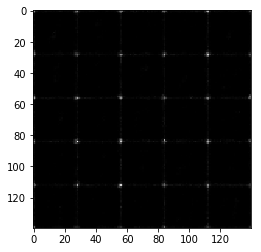

Iteration 210 -- Epoch 1/2 -- Discriminator loss: 1.37784 -- Generator loss: 0.65898
Iteration 220 -- Epoch 1/2 -- Discriminator loss: 1.34044 -- Generator loss: 0.61353
Iteration 230 -- Epoch 1/2 -- Discriminator loss: 1.38408 -- Generator loss: 0.69257
Iteration 240 -- Epoch 1/2 -- Discriminator loss: 1.37591 -- Generator loss: 0.60953
Iteration 250 -- Epoch 1/2 -- Discriminator loss: 1.35158 -- Generator loss: 0.67383
Iteration 260 -- Epoch 1/2 -- Discriminator loss: 1.35102 -- Generator loss: 0.65930
Iteration 270 -- Epoch 1/2 -- Discriminator loss: 1.35555 -- Generator loss: 0.67720
Iteration 280 -- Epoch 1/2 -- Discriminator loss: 1.37933 -- Generator loss: 0.69142
Iteration 290 -- Epoch 1/2 -- Discriminator loss: 1.38189 -- Generator loss: 0.67394
Iteration 300 -- Epoch 1/2 -- Discriminator loss: 1.35935 -- Generator loss: 0.65825


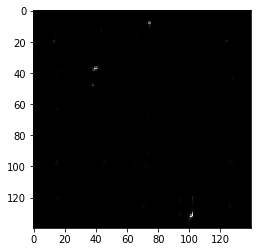

Iteration 310 -- Epoch 1/2 -- Discriminator loss: 1.37187 -- Generator loss: 0.66253
Iteration 320 -- Epoch 1/2 -- Discriminator loss: 1.37283 -- Generator loss: 0.68663
Iteration 330 -- Epoch 1/2 -- Discriminator loss: 1.37762 -- Generator loss: 0.64169
Iteration 340 -- Epoch 1/2 -- Discriminator loss: 1.33308 -- Generator loss: 0.63118
Iteration 350 -- Epoch 1/2 -- Discriminator loss: 1.33508 -- Generator loss: 0.67788
Iteration 360 -- Epoch 1/2 -- Discriminator loss: 1.29507 -- Generator loss: 0.64162
Iteration 370 -- Epoch 1/2 -- Discriminator loss: 1.28879 -- Generator loss: 0.63946
Iteration 380 -- Epoch 1/2 -- Discriminator loss: 1.34169 -- Generator loss: 0.60157
Iteration 390 -- Epoch 1/2 -- Discriminator loss: 1.29199 -- Generator loss: 0.65953
Iteration 400 -- Epoch 1/2 -- Discriminator loss: 1.30141 -- Generator loss: 0.67150


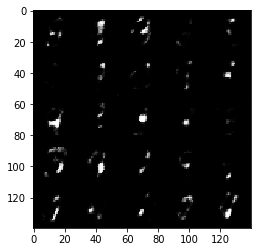

Iteration 410 -- Epoch 1/2 -- Discriminator loss: 1.23808 -- Generator loss: 0.67670
Iteration 420 -- Epoch 1/2 -- Discriminator loss: 1.31286 -- Generator loss: 0.66503
Iteration 430 -- Epoch 1/2 -- Discriminator loss: 1.33562 -- Generator loss: 0.61439
Iteration 440 -- Epoch 1/2 -- Discriminator loss: 1.32321 -- Generator loss: 0.67844
Iteration 450 -- Epoch 1/2 -- Discriminator loss: 1.28627 -- Generator loss: 0.63008
Iteration 460 -- Epoch 1/2 -- Discriminator loss: 1.26766 -- Generator loss: 0.65504
Iteration 470 -- Epoch 1/2 -- Discriminator loss: 1.31793 -- Generator loss: 0.63814
Iteration 480 -- Epoch 1/2 -- Discriminator loss: 1.24266 -- Generator loss: 0.65015
Iteration 490 -- Epoch 1/2 -- Discriminator loss: 1.30381 -- Generator loss: 0.67942
Iteration 500 -- Epoch 1/2 -- Discriminator loss: 1.36153 -- Generator loss: 0.68446


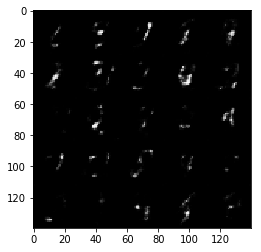

Iteration 510 -- Epoch 1/2 -- Discriminator loss: 1.35077 -- Generator loss: 0.65973
Iteration 520 -- Epoch 1/2 -- Discriminator loss: 1.29912 -- Generator loss: 0.59143
Iteration 530 -- Epoch 1/2 -- Discriminator loss: 1.28186 -- Generator loss: 0.68056
Iteration 540 -- Epoch 1/2 -- Discriminator loss: 1.29935 -- Generator loss: 0.67775
Iteration 550 -- Epoch 1/2 -- Discriminator loss: 1.33539 -- Generator loss: 0.67039
Iteration 560 -- Epoch 1/2 -- Discriminator loss: 1.32468 -- Generator loss: 0.65905
Iteration 570 -- Epoch 1/2 -- Discriminator loss: 1.35714 -- Generator loss: 0.65348
Iteration 580 -- Epoch 1/2 -- Discriminator loss: 1.29706 -- Generator loss: 0.66939
Iteration 590 -- Epoch 1/2 -- Discriminator loss: 1.32719 -- Generator loss: 0.67739
Iteration 600 -- Epoch 1/2 -- Discriminator loss: 1.29305 -- Generator loss: 0.64152


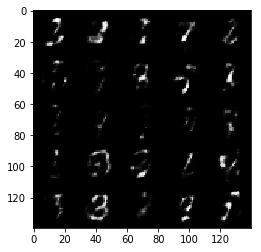

Iteration 610 -- Epoch 1/2 -- Discriminator loss: 1.28712 -- Generator loss: 0.66769
Iteration 620 -- Epoch 1/2 -- Discriminator loss: 1.34353 -- Generator loss: 0.57047
Iteration 630 -- Epoch 1/2 -- Discriminator loss: 1.28145 -- Generator loss: 0.65167
Iteration 640 -- Epoch 1/2 -- Discriminator loss: 1.35697 -- Generator loss: 0.64848
Iteration 650 -- Epoch 1/2 -- Discriminator loss: 1.28538 -- Generator loss: 0.64399
Iteration 660 -- Epoch 1/2 -- Discriminator loss: 1.35551 -- Generator loss: 0.65550
Iteration 670 -- Epoch 1/2 -- Discriminator loss: 1.30220 -- Generator loss: 0.59913
Iteration 680 -- Epoch 1/2 -- Discriminator loss: 1.33309 -- Generator loss: 0.65147
Iteration 690 -- Epoch 1/2 -- Discriminator loss: 1.45098 -- Generator loss: 0.58046
Iteration 700 -- Epoch 1/2 -- Discriminator loss: 1.43398 -- Generator loss: 0.64725


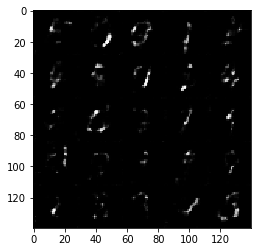

Iteration 710 -- Epoch 1/2 -- Discriminator loss: 1.36377 -- Generator loss: 0.52783
Iteration 720 -- Epoch 1/2 -- Discriminator loss: 1.33603 -- Generator loss: 0.59325
Iteration 730 -- Epoch 1/2 -- Discriminator loss: 1.27202 -- Generator loss: 0.65320
Iteration 740 -- Epoch 1/2 -- Discriminator loss: 1.38085 -- Generator loss: 0.62170
Iteration 750 -- Epoch 1/2 -- Discriminator loss: 1.32756 -- Generator loss: 0.60724
Iteration 760 -- Epoch 1/2 -- Discriminator loss: 1.35927 -- Generator loss: 0.68758
Iteration 770 -- Epoch 1/2 -- Discriminator loss: 1.27480 -- Generator loss: 0.64595
Iteration 780 -- Epoch 1/2 -- Discriminator loss: 1.31271 -- Generator loss: 0.64820
Iteration 790 -- Epoch 1/2 -- Discriminator loss: 1.32217 -- Generator loss: 0.61164
Iteration 800 -- Epoch 1/2 -- Discriminator loss: 1.36671 -- Generator loss: 0.61825


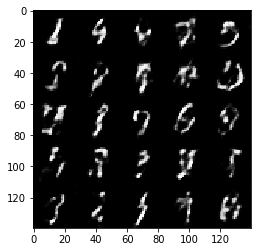

Iteration 810 -- Epoch 1/2 -- Discriminator loss: 1.27468 -- Generator loss: 0.64627
Iteration 820 -- Epoch 1/2 -- Discriminator loss: 1.28179 -- Generator loss: 0.65734
Iteration 830 -- Epoch 1/2 -- Discriminator loss: 1.31139 -- Generator loss: 0.65286
Iteration 840 -- Epoch 1/2 -- Discriminator loss: 1.26796 -- Generator loss: 0.66312
Iteration 850 -- Epoch 1/2 -- Discriminator loss: 1.28796 -- Generator loss: 0.65957
Iteration 860 -- Epoch 1/2 -- Discriminator loss: 1.33846 -- Generator loss: 0.62365
Iteration 870 -- Epoch 1/2 -- Discriminator loss: 1.27333 -- Generator loss: 0.63596
Iteration 880 -- Epoch 1/2 -- Discriminator loss: 1.29431 -- Generator loss: 0.66272
Iteration 890 -- Epoch 1/2 -- Discriminator loss: 1.31707 -- Generator loss: 0.68363
Iteration 900 -- Epoch 1/2 -- Discriminator loss: 1.34247 -- Generator loss: 0.68191


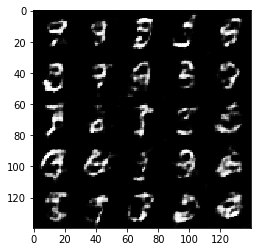

Iteration 910 -- Epoch 1/2 -- Discriminator loss: 1.27622 -- Generator loss: 0.61919
Iteration 920 -- Epoch 1/2 -- Discriminator loss: 1.33236 -- Generator loss: 0.62035
Iteration 930 -- Epoch 1/2 -- Discriminator loss: 1.33061 -- Generator loss: 0.60637
Iteration  10 -- Epoch 2/2 -- Discriminator loss: 1.31458 -- Generator loss: 0.67703
Iteration  20 -- Epoch 2/2 -- Discriminator loss: 1.37139 -- Generator loss: 0.55092
Iteration  30 -- Epoch 2/2 -- Discriminator loss: 1.30166 -- Generator loss: 0.65273
Iteration  40 -- Epoch 2/2 -- Discriminator loss: 1.29437 -- Generator loss: 0.64882
Iteration  50 -- Epoch 2/2 -- Discriminator loss: 1.29587 -- Generator loss: 0.64993
Iteration  60 -- Epoch 2/2 -- Discriminator loss: 1.35447 -- Generator loss: 0.68603
Iteration  70 -- Epoch 2/2 -- Discriminator loss: 1.32077 -- Generator loss: 0.60051
Iteration  80 -- Epoch 2/2 -- Discriminator loss: 1.23315 -- Generator loss: 0.66875
Iteration  90 -- Epoch 2/2 -- Discriminator loss: 1.34191 -- Gene

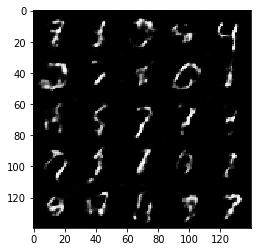

Iteration 110 -- Epoch 2/2 -- Discriminator loss: 1.38024 -- Generator loss: 0.69311
Iteration 120 -- Epoch 2/2 -- Discriminator loss: 1.24091 -- Generator loss: 0.68662
Iteration 130 -- Epoch 2/2 -- Discriminator loss: 1.39278 -- Generator loss: 0.69025
Iteration 140 -- Epoch 2/2 -- Discriminator loss: 1.35708 -- Generator loss: 0.67910
Iteration 150 -- Epoch 2/2 -- Discriminator loss: 1.35775 -- Generator loss: 0.58103
Iteration 160 -- Epoch 2/2 -- Discriminator loss: 1.23952 -- Generator loss: 0.64947
Iteration 170 -- Epoch 2/2 -- Discriminator loss: 1.23099 -- Generator loss: 0.65267
Iteration 180 -- Epoch 2/2 -- Discriminator loss: 1.31212 -- Generator loss: 0.66687
Iteration 190 -- Epoch 2/2 -- Discriminator loss: 1.27782 -- Generator loss: 0.64155
Iteration 200 -- Epoch 2/2 -- Discriminator loss: 1.23431 -- Generator loss: 0.68422


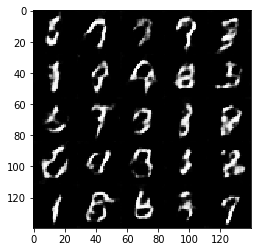

Iteration 210 -- Epoch 2/2 -- Discriminator loss: 1.30920 -- Generator loss: 0.68332
Iteration 220 -- Epoch 2/2 -- Discriminator loss: 1.33230 -- Generator loss: 0.62565
Iteration 230 -- Epoch 2/2 -- Discriminator loss: 1.33450 -- Generator loss: 0.66119
Iteration 240 -- Epoch 2/2 -- Discriminator loss: 1.27882 -- Generator loss: 0.67090
Iteration 250 -- Epoch 2/2 -- Discriminator loss: 1.38310 -- Generator loss: 0.69267
Iteration 260 -- Epoch 2/2 -- Discriminator loss: 1.27135 -- Generator loss: 0.63636
Iteration 270 -- Epoch 2/2 -- Discriminator loss: 1.29446 -- Generator loss: 0.64593
Iteration 280 -- Epoch 2/2 -- Discriminator loss: 1.40219 -- Generator loss: 0.63886
Iteration 290 -- Epoch 2/2 -- Discriminator loss: 1.34282 -- Generator loss: 0.67710
Iteration 300 -- Epoch 2/2 -- Discriminator loss: 1.30024 -- Generator loss: 0.63119


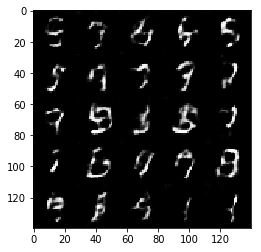

Iteration 310 -- Epoch 2/2 -- Discriminator loss: 1.27958 -- Generator loss: 0.65145
Iteration 320 -- Epoch 2/2 -- Discriminator loss: 1.35813 -- Generator loss: 0.65897
Iteration 330 -- Epoch 2/2 -- Discriminator loss: 1.34393 -- Generator loss: 0.61569
Iteration 340 -- Epoch 2/2 -- Discriminator loss: 1.34757 -- Generator loss: 0.64751
Iteration 350 -- Epoch 2/2 -- Discriminator loss: 1.33826 -- Generator loss: 0.67092
Iteration 360 -- Epoch 2/2 -- Discriminator loss: 1.37068 -- Generator loss: 0.63748
Iteration 370 -- Epoch 2/2 -- Discriminator loss: 1.33768 -- Generator loss: 0.68432
Iteration 380 -- Epoch 2/2 -- Discriminator loss: 1.32923 -- Generator loss: 0.65778
Iteration 390 -- Epoch 2/2 -- Discriminator loss: 1.31860 -- Generator loss: 0.66723
Iteration 400 -- Epoch 2/2 -- Discriminator loss: 1.31557 -- Generator loss: 0.62402


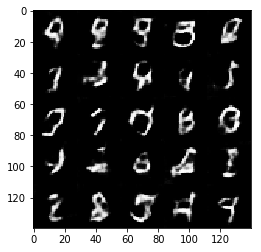

Iteration 410 -- Epoch 2/2 -- Discriminator loss: 1.29145 -- Generator loss: 0.67219
Iteration 420 -- Epoch 2/2 -- Discriminator loss: 1.35366 -- Generator loss: 0.68865
Iteration 430 -- Epoch 2/2 -- Discriminator loss: 1.30649 -- Generator loss: 0.65773
Iteration 440 -- Epoch 2/2 -- Discriminator loss: 1.27151 -- Generator loss: 0.63487
Iteration 450 -- Epoch 2/2 -- Discriminator loss: 1.32508 -- Generator loss: 0.66145
Iteration 460 -- Epoch 2/2 -- Discriminator loss: 1.31191 -- Generator loss: 0.66017
Iteration 470 -- Epoch 2/2 -- Discriminator loss: 1.31461 -- Generator loss: 0.65711
Iteration 480 -- Epoch 2/2 -- Discriminator loss: 1.35298 -- Generator loss: 0.68113
Iteration 490 -- Epoch 2/2 -- Discriminator loss: 1.34414 -- Generator loss: 0.65919
Iteration 500 -- Epoch 2/2 -- Discriminator loss: 1.31961 -- Generator loss: 0.66505


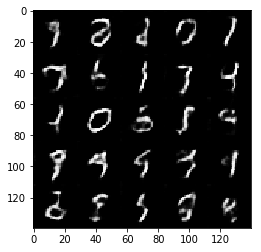

Iteration 510 -- Epoch 2/2 -- Discriminator loss: 1.32031 -- Generator loss: 0.65988
Iteration 520 -- Epoch 2/2 -- Discriminator loss: 1.28198 -- Generator loss: 0.65911
Iteration 530 -- Epoch 2/2 -- Discriminator loss: 1.31724 -- Generator loss: 0.65964
Iteration 540 -- Epoch 2/2 -- Discriminator loss: 1.34161 -- Generator loss: 0.67191
Iteration 550 -- Epoch 2/2 -- Discriminator loss: 1.29871 -- Generator loss: 0.66294
Iteration 560 -- Epoch 2/2 -- Discriminator loss: 1.33654 -- Generator loss: 0.65304
Iteration 570 -- Epoch 2/2 -- Discriminator loss: 1.30011 -- Generator loss: 0.68052
Iteration 580 -- Epoch 2/2 -- Discriminator loss: 1.29117 -- Generator loss: 0.68283
Iteration 590 -- Epoch 2/2 -- Discriminator loss: 1.34080 -- Generator loss: 0.63210
Iteration 600 -- Epoch 2/2 -- Discriminator loss: 1.28718 -- Generator loss: 0.67597


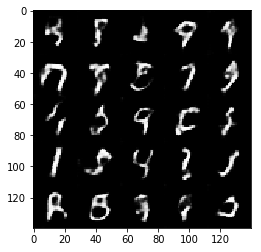

Iteration 610 -- Epoch 2/2 -- Discriminator loss: 1.34371 -- Generator loss: 0.61298
Iteration 620 -- Epoch 2/2 -- Discriminator loss: 1.31234 -- Generator loss: 0.62849
Iteration 630 -- Epoch 2/2 -- Discriminator loss: 1.31499 -- Generator loss: 0.63962
Iteration 640 -- Epoch 2/2 -- Discriminator loss: 1.33369 -- Generator loss: 0.67496
Iteration 650 -- Epoch 2/2 -- Discriminator loss: 1.30902 -- Generator loss: 0.66014
Iteration 660 -- Epoch 2/2 -- Discriminator loss: 1.38313 -- Generator loss: 0.69279
Iteration 670 -- Epoch 2/2 -- Discriminator loss: 1.39230 -- Generator loss: 0.63308
Iteration 680 -- Epoch 2/2 -- Discriminator loss: 1.34037 -- Generator loss: 0.63129
Iteration 690 -- Epoch 2/2 -- Discriminator loss: 1.36424 -- Generator loss: 0.68670
Iteration 700 -- Epoch 2/2 -- Discriminator loss: 1.34856 -- Generator loss: 0.62995


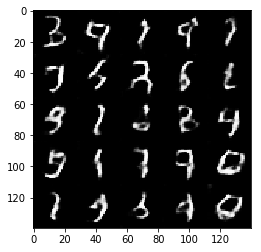

Iteration 710 -- Epoch 2/2 -- Discriminator loss: 1.35932 -- Generator loss: 0.66324
Iteration 720 -- Epoch 2/2 -- Discriminator loss: 1.34774 -- Generator loss: 0.63904
Iteration 730 -- Epoch 2/2 -- Discriminator loss: 1.34540 -- Generator loss: 0.67765
Iteration 740 -- Epoch 2/2 -- Discriminator loss: 1.32582 -- Generator loss: 0.64785
Iteration 750 -- Epoch 2/2 -- Discriminator loss: 1.27687 -- Generator loss: 0.66061
Iteration 760 -- Epoch 2/2 -- Discriminator loss: 1.34379 -- Generator loss: 0.55765
Iteration 770 -- Epoch 2/2 -- Discriminator loss: 1.30195 -- Generator loss: 0.63483
Iteration 780 -- Epoch 2/2 -- Discriminator loss: 1.33603 -- Generator loss: 0.59986
Iteration 790 -- Epoch 2/2 -- Discriminator loss: 1.38419 -- Generator loss: 0.62560
Iteration 800 -- Epoch 2/2 -- Discriminator loss: 1.35547 -- Generator loss: 0.67054


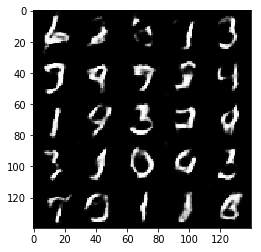

Iteration 810 -- Epoch 2/2 -- Discriminator loss: 1.39860 -- Generator loss: 0.67659
Iteration 820 -- Epoch 2/2 -- Discriminator loss: 1.38605 -- Generator loss: 0.69309
Iteration 830 -- Epoch 2/2 -- Discriminator loss: 1.31739 -- Generator loss: 0.64540
Iteration 840 -- Epoch 2/2 -- Discriminator loss: 1.37166 -- Generator loss: 0.67679
Iteration 850 -- Epoch 2/2 -- Discriminator loss: 1.38687 -- Generator loss: 0.68224
Iteration 860 -- Epoch 2/2 -- Discriminator loss: 1.32100 -- Generator loss: 0.61416
Iteration 870 -- Epoch 2/2 -- Discriminator loss: 1.33597 -- Generator loss: 0.66523
Iteration 880 -- Epoch 2/2 -- Discriminator loss: 1.37817 -- Generator loss: 0.64304
Iteration 890 -- Epoch 2/2 -- Discriminator loss: 1.31893 -- Generator loss: 0.67323
Iteration 900 -- Epoch 2/2 -- Discriminator loss: 1.30355 -- Generator loss: 0.64509


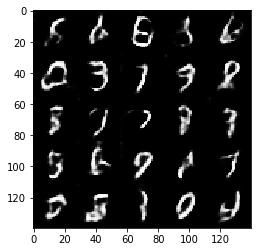

Iteration 910 -- Epoch 2/2 -- Discriminator loss: 1.27882 -- Generator loss: 0.64083
Iteration 920 -- Epoch 2/2 -- Discriminator loss: 1.29499 -- Generator loss: 0.65663
Iteration 930 -- Epoch 2/2 -- Discriminator loss: 1.38569 -- Generator loss: 0.69306


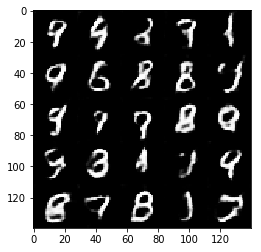

Done!


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Iteration  10 -- Epoch 1/1 -- Discriminator loss: 1.23394 -- Generator loss: 0.66133
Iteration  20 -- Epoch 1/1 -- Discriminator loss: 1.20270 -- Generator loss: 0.66213
Iteration  30 -- Epoch 1/1 -- Discriminator loss: 1.18966 -- Generator loss: 0.66969
Iteration  40 -- Epoch 1/1 -- Discriminator loss: 1.17576 -- Generator loss: 0.67873
Iteration  50 -- Epoch 1/1 -- Discriminator loss: 1.13875 -- Generator loss: 0.68593
Iteration  60 -- Epoch 1/1 -- Discriminator loss: 1.12738 -- Generator loss: 0.66357
Iteration  70 -- Epoch 1/1 -- Discriminator loss: 1.13282 -- Generator loss: 0.67715
Iteration  80 -- Epoch 1/1 -- Discriminator loss: 1.13798 -- Generator loss: 0.67563
Iteration  90 -- Epoch 1/1 -- Discriminator loss: 1.15463 -- Generator loss: 0.67067
Iteration 100 -- Epoch 1/1 -- Discriminator loss: 1.12122 -- Generator loss: 0.69061


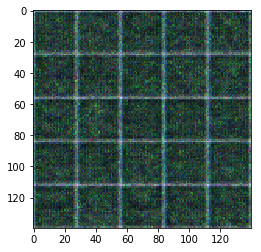

Iteration 110 -- Epoch 1/1 -- Discriminator loss: 1.12479 -- Generator loss: 0.67571
Iteration 120 -- Epoch 1/1 -- Discriminator loss: 1.12261 -- Generator loss: 0.68415
Iteration 130 -- Epoch 1/1 -- Discriminator loss: 1.13050 -- Generator loss: 0.68919
Iteration 140 -- Epoch 1/1 -- Discriminator loss: 1.12964 -- Generator loss: 0.68924
Iteration 150 -- Epoch 1/1 -- Discriminator loss: 1.11750 -- Generator loss: 0.68555
Iteration 160 -- Epoch 1/1 -- Discriminator loss: 1.10898 -- Generator loss: 0.67803
Iteration 170 -- Epoch 1/1 -- Discriminator loss: 1.13406 -- Generator loss: 0.69102
Iteration 180 -- Epoch 1/1 -- Discriminator loss: 1.11292 -- Generator loss: 0.69000
Iteration 190 -- Epoch 1/1 -- Discriminator loss: 1.12274 -- Generator loss: 0.68224
Iteration 200 -- Epoch 1/1 -- Discriminator loss: 1.10758 -- Generator loss: 0.69273


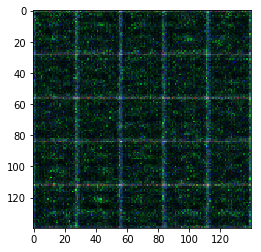

Iteration 210 -- Epoch 1/1 -- Discriminator loss: 1.10901 -- Generator loss: 0.68405
Iteration 220 -- Epoch 1/1 -- Discriminator loss: 1.12160 -- Generator loss: 0.68498
Iteration 230 -- Epoch 1/1 -- Discriminator loss: 1.10750 -- Generator loss: 0.69230
Iteration 240 -- Epoch 1/1 -- Discriminator loss: 1.10722 -- Generator loss: 0.69278
Iteration 250 -- Epoch 1/1 -- Discriminator loss: 1.10758 -- Generator loss: 0.69225
Iteration 260 -- Epoch 1/1 -- Discriminator loss: 1.11065 -- Generator loss: 0.69299
Iteration 270 -- Epoch 1/1 -- Discriminator loss: 1.11096 -- Generator loss: 0.68450
Iteration 280 -- Epoch 1/1 -- Discriminator loss: 1.11006 -- Generator loss: 0.69290
Iteration 290 -- Epoch 1/1 -- Discriminator loss: 1.10705 -- Generator loss: 0.69280
Iteration 300 -- Epoch 1/1 -- Discriminator loss: 1.10753 -- Generator loss: 0.69164


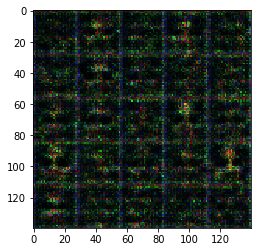

Iteration 310 -- Epoch 1/1 -- Discriminator loss: 1.10714 -- Generator loss: 0.69278
Iteration 320 -- Epoch 1/1 -- Discriminator loss: 1.10724 -- Generator loss: 0.69288
Iteration 330 -- Epoch 1/1 -- Discriminator loss: 1.10668 -- Generator loss: 0.69265
Iteration 340 -- Epoch 1/1 -- Discriminator loss: 1.10703 -- Generator loss: 0.69224
Iteration 350 -- Epoch 1/1 -- Discriminator loss: 1.10807 -- Generator loss: 0.69242
Iteration 360 -- Epoch 1/1 -- Discriminator loss: 1.10668 -- Generator loss: 0.69290
Iteration 370 -- Epoch 1/1 -- Discriminator loss: 1.10652 -- Generator loss: 0.69262
Iteration 380 -- Epoch 1/1 -- Discriminator loss: 1.10689 -- Generator loss: 0.69283
Iteration 390 -- Epoch 1/1 -- Discriminator loss: 1.10666 -- Generator loss: 0.69308
Iteration 400 -- Epoch 1/1 -- Discriminator loss: 1.10676 -- Generator loss: 0.69301


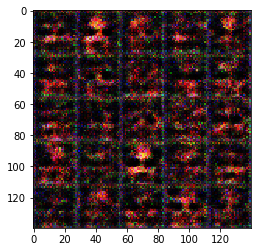

Iteration 410 -- Epoch 1/1 -- Discriminator loss: 1.10670 -- Generator loss: 0.69305
Iteration 420 -- Epoch 1/1 -- Discriminator loss: 1.10704 -- Generator loss: 0.69311
Iteration 430 -- Epoch 1/1 -- Discriminator loss: 1.10661 -- Generator loss: 0.69294
Iteration 440 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69266
Iteration 450 -- Epoch 1/1 -- Discriminator loss: 1.10765 -- Generator loss: 0.69285
Iteration 460 -- Epoch 1/1 -- Discriminator loss: 1.10662 -- Generator loss: 0.69307
Iteration 470 -- Epoch 1/1 -- Discriminator loss: 1.10684 -- Generator loss: 0.69285
Iteration 480 -- Epoch 1/1 -- Discriminator loss: 1.10689 -- Generator loss: 0.69297
Iteration 490 -- Epoch 1/1 -- Discriminator loss: 1.10674 -- Generator loss: 0.69284
Iteration 500 -- Epoch 1/1 -- Discriminator loss: 1.10655 -- Generator loss: 0.69309


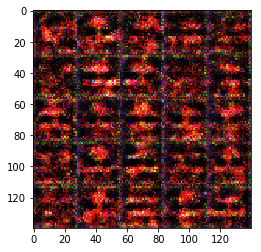

Iteration 510 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69310
Iteration 520 -- Epoch 1/1 -- Discriminator loss: 1.10649 -- Generator loss: 0.69313
Iteration 530 -- Epoch 1/1 -- Discriminator loss: 1.10710 -- Generator loss: 0.69304
Iteration 540 -- Epoch 1/1 -- Discriminator loss: 1.10647 -- Generator loss: 0.69311
Iteration 550 -- Epoch 1/1 -- Discriminator loss: 1.10660 -- Generator loss: 0.69311
Iteration 560 -- Epoch 1/1 -- Discriminator loss: 1.10700 -- Generator loss: 0.69310
Iteration 570 -- Epoch 1/1 -- Discriminator loss: 1.10656 -- Generator loss: 0.69313
Iteration 580 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69313
Iteration 590 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69310
Iteration 600 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69306


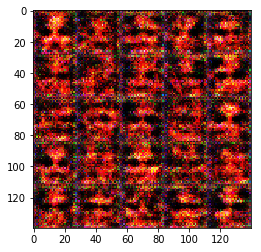

Iteration 610 -- Epoch 1/1 -- Discriminator loss: 1.10669 -- Generator loss: 0.69312
Iteration 620 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69313
Iteration 630 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69308
Iteration 640 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69312
Iteration 650 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69310
Iteration 660 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69312
Iteration 670 -- Epoch 1/1 -- Discriminator loss: 1.10646 -- Generator loss: 0.69310
Iteration 680 -- Epoch 1/1 -- Discriminator loss: 1.10660 -- Generator loss: 0.69309
Iteration 690 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69312
Iteration 700 -- Epoch 1/1 -- Discriminator loss: 1.10697 -- Generator loss: 0.69313


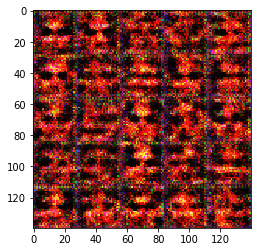

Iteration 710 -- Epoch 1/1 -- Discriminator loss: 1.10708 -- Generator loss: 0.69298
Iteration 720 -- Epoch 1/1 -- Discriminator loss: 1.10649 -- Generator loss: 0.69313
Iteration 730 -- Epoch 1/1 -- Discriminator loss: 1.10657 -- Generator loss: 0.69313
Iteration 740 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69313
Iteration 750 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69314
Iteration 760 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69313
Iteration 770 -- Epoch 1/1 -- Discriminator loss: 1.10658 -- Generator loss: 0.69295
Iteration 780 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69313
Iteration 790 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 800 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314


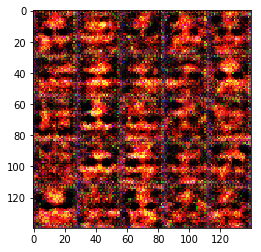

Iteration 810 -- Epoch 1/1 -- Discriminator loss: 1.10646 -- Generator loss: 0.69313
Iteration 820 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69314
Iteration 830 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69311
Iteration 840 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69312
Iteration 850 -- Epoch 1/1 -- Discriminator loss: 1.10646 -- Generator loss: 0.69310
Iteration 860 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69312
Iteration 870 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69313
Iteration 880 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69312
Iteration 890 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 900 -- Epoch 1/1 -- Discriminator loss: 1.10660 -- Generator loss: 0.69312


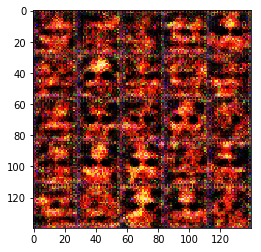

Iteration 910 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69313
Iteration 920 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 930 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69313
Iteration 940 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69312
Iteration 950 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69313
Iteration 960 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 970 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69314
Iteration 980 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69311
Iteration 990 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69314
Iteration 1000 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


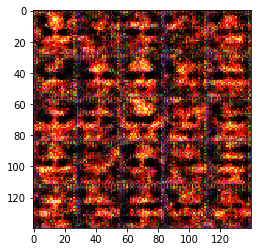

Iteration 1010 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1020 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69313
Iteration 1030 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1040 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1050 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69311
Iteration 1060 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1070 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 1080 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69313
Iteration 1090 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69311
Iteration 1100 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


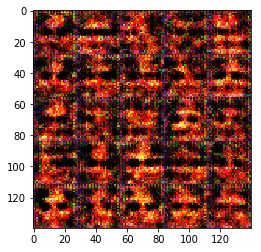

Iteration 1110 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314
Iteration 1120 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1130 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69304
Iteration 1140 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1150 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314
Iteration 1160 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69314
Iteration 1170 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69314
Iteration 1180 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1190 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69313
Iteration 1200 -- Epoch 1/1 -- Discriminator loss: 1.10646 -- Generator loss: 0.69314


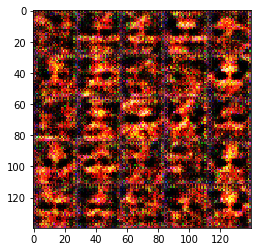

Iteration 1210 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1220 -- Epoch 1/1 -- Discriminator loss: 1.10647 -- Generator loss: 0.69314
Iteration 1230 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69312
Iteration 1240 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1250 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1260 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1270 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69313
Iteration 1280 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1290 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69313
Iteration 1300 -- Epoch 1/1 -- Discriminator loss: 1.10692 -- Generator loss: 0.69307


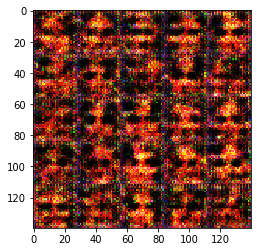

Iteration 1310 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1320 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69305
Iteration 1330 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1340 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69312
Iteration 1350 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1360 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1370 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1380 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1390 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1400 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


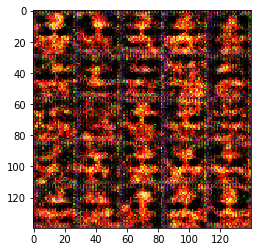

Iteration 1410 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69315
Iteration 1420 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1430 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69314
Iteration 1440 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1450 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1460 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1470 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1480 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1490 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 1500 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


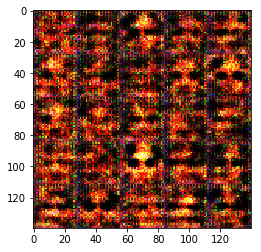

Iteration 1510 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1520 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1530 -- Epoch 1/1 -- Discriminator loss: 1.10650 -- Generator loss: 0.69312
Iteration 1540 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1550 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1560 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69315
Iteration 1570 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69313
Iteration 1580 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1590 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 1600 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


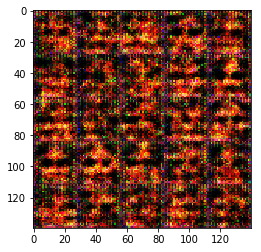

Iteration 1610 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1620 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1630 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1640 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 1650 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69315
Iteration 1660 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1670 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 1680 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 1690 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69315
Iteration 1700 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


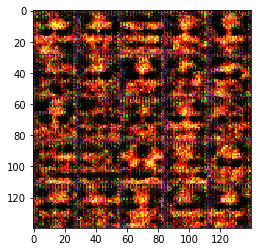

Iteration 1710 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314
Iteration 1720 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1730 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1740 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 1750 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1760 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1770 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1780 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1790 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1800 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


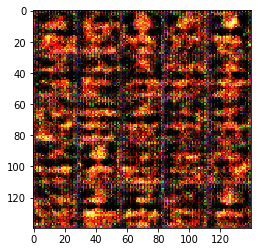

Iteration 1810 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 1820 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69313
Iteration 1830 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1840 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1850 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1860 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1870 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1880 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1890 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1900 -- Epoch 1/1 -- Discriminator loss: 1.10647 -- Generator loss: 0.69314


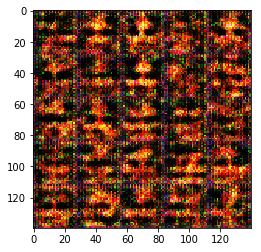

Iteration 1910 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1920 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1930 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1940 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1950 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1960 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 1970 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314
Iteration 1980 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 1990 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2000 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


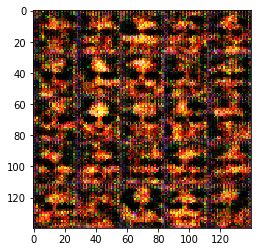

Iteration 2010 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2020 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2030 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2040 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2050 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 2060 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2070 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2080 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2090 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2100 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


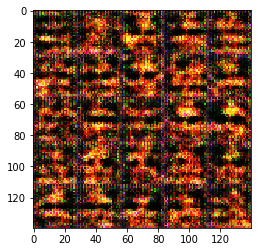

Iteration 2110 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2120 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2130 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2140 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 2150 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2160 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2170 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2180 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2190 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2200 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69312


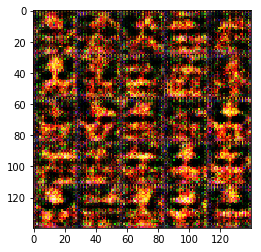

Iteration 2210 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2220 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69314
Iteration 2230 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2240 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2250 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 2260 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2270 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2280 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2290 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2300 -- Epoch 1/1 -- Discriminator loss: 1.10724 -- Generator loss: 0.69315


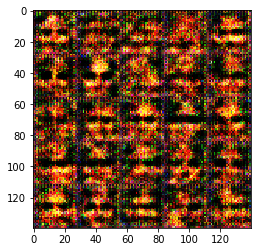

Iteration 2310 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2320 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2330 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2340 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 2350 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2360 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2370 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 2380 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2390 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2400 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315


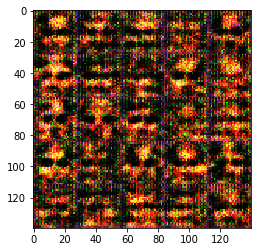

Iteration 2410 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2420 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2430 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2440 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 2450 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2460 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2470 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2480 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2490 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2500 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


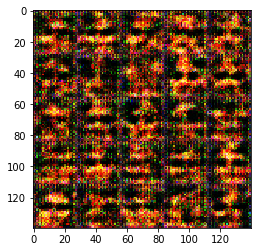

Iteration 2510 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2520 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2530 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2540 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2550 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69315
Iteration 2560 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2570 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2580 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2590 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 2600 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69312


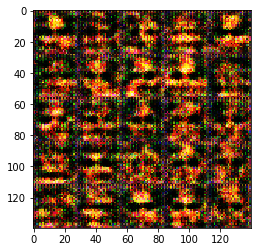

Iteration 2610 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2620 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2630 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2640 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2650 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2660 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314
Iteration 2670 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2680 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2690 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2700 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314


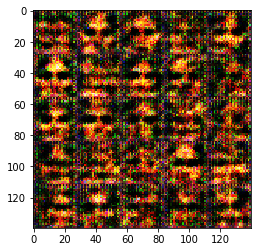

Iteration 2710 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2720 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2730 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2740 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2750 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2760 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2770 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2780 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2790 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2800 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


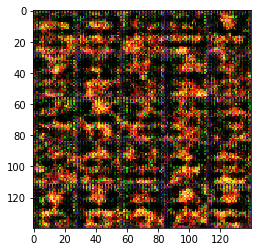

Iteration 2810 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69313
Iteration 2820 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2830 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69314
Iteration 2840 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2850 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2860 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2870 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 2880 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2890 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2900 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


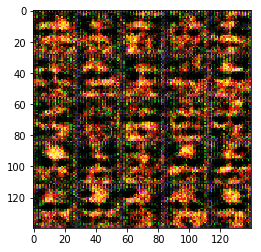

Iteration 2910 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2920 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2930 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69315
Iteration 2940 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2950 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 2960 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 2970 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2980 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 2990 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3000 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


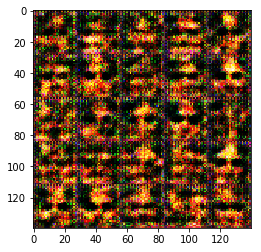

Iteration 3010 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3020 -- Epoch 1/1 -- Discriminator loss: 1.10647 -- Generator loss: 0.69310
Iteration 3030 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 3040 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3050 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3060 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3070 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3080 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3090 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3100 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


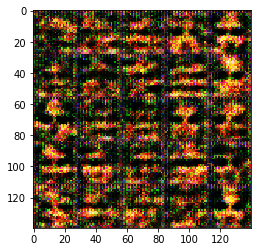

Iteration 3110 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69314
Iteration 3120 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3130 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3140 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3150 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3160 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3170 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3180 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3190 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3200 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


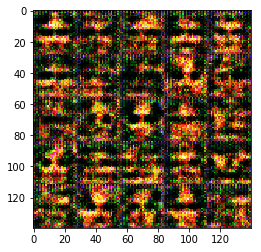

Iteration 3210 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3220 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3230 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3240 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3250 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 3260 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3270 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3280 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3290 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3300 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315


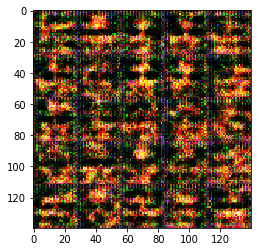

Iteration 3310 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3320 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3330 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3340 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3350 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3360 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3370 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3380 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3390 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3400 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


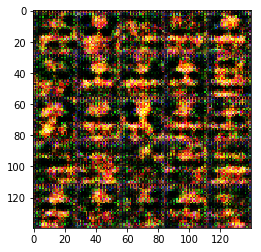

Iteration 3410 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3420 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3430 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3440 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3450 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3460 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3470 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69315
Iteration 3480 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3490 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69313
Iteration 3500 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314


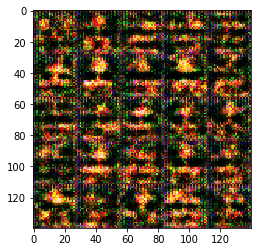

Iteration 3510 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3520 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3530 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3540 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3550 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3560 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3570 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3580 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3590 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3600 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


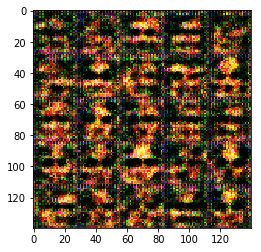

Iteration 3610 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3620 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3630 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3640 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3650 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3660 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3670 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3680 -- Epoch 1/1 -- Discriminator loss: 1.10643 -- Generator loss: 0.69315
Iteration 3690 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3700 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


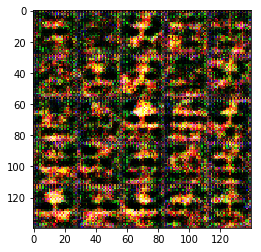

Iteration 3710 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3720 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3730 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3740 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3750 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3760 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3770 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3780 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3790 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3800 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


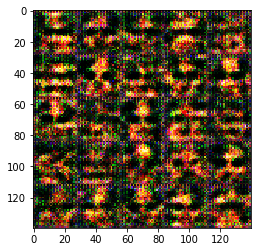

Iteration 3810 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 3820 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3830 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3840 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3850 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3860 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3870 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3880 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3890 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3900 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


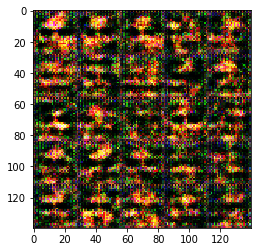

Iteration 3910 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3920 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 3930 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3940 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3950 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3960 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3970 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3980 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 3990 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4000 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


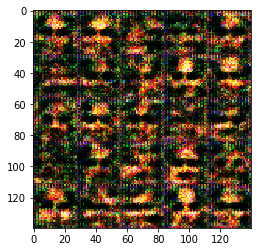

Iteration 4010 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4020 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4030 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4040 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4050 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4060 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4070 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4080 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4090 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4100 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


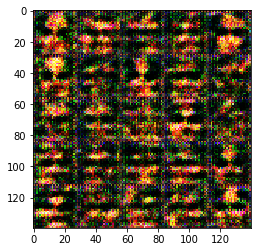

Iteration 4110 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4120 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4130 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4140 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4150 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4160 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4170 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4180 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4190 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4200 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


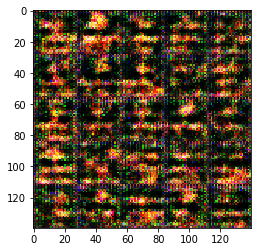

Iteration 4210 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4220 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4230 -- Epoch 1/1 -- Discriminator loss: 1.10905 -- Generator loss: 0.69315
Iteration 4240 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4250 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4260 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4270 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4280 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4290 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4300 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


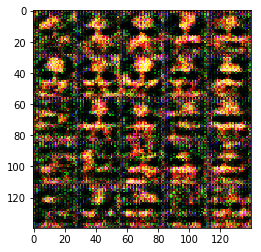

Iteration 4310 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4320 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 4330 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4340 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 4350 -- Epoch 1/1 -- Discriminator loss: 1.10645 -- Generator loss: 0.69314
Iteration 4360 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4370 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4380 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 4390 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4400 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


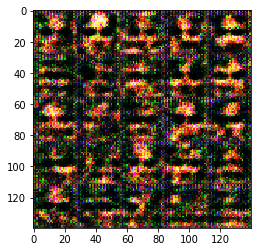

Iteration 4410 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4420 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4430 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4440 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4450 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4460 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4470 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4480 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4490 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4500 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


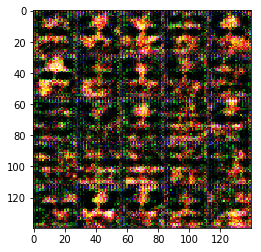

Iteration 4510 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4520 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4530 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4540 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4550 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4560 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4570 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4580 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 4590 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4600 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


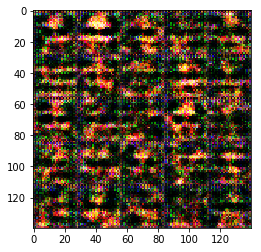

Iteration 4610 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4620 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4630 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4640 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4650 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4660 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4670 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4680 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4690 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4700 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


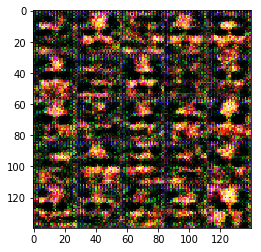

Iteration 4710 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4720 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4730 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4740 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4750 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4760 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4770 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4780 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4790 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4800 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314


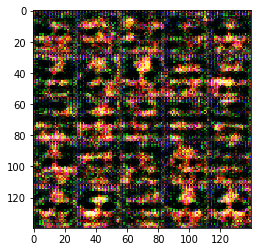

Iteration 4810 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4820 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4830 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4840 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4850 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4860 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4870 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4880 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4890 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4900 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


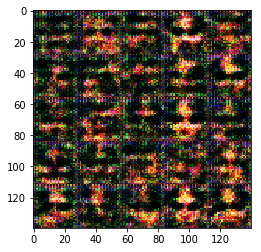

Iteration 4910 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 4920 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4930 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4940 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4950 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4960 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4970 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 4980 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 4990 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5000 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


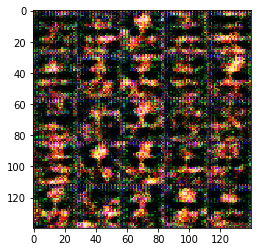

Iteration 5010 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5020 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5030 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5040 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5050 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5060 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5070 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5080 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5090 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5100 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


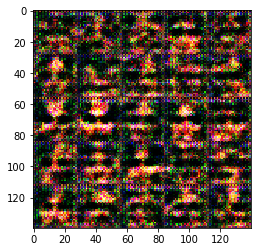

Iteration 5110 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5120 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5130 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5140 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5150 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5160 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5170 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5180 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5190 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5200 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


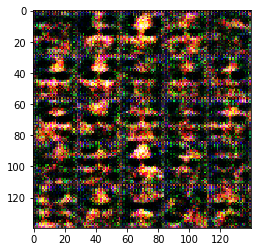

Iteration 5210 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5220 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5230 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5240 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5250 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5260 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5270 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5280 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5290 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5300 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314


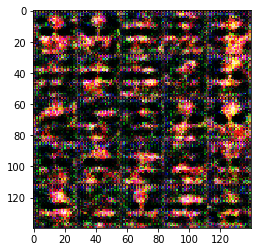

Iteration 5310 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5320 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5330 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5340 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5350 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5360 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5370 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5380 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5390 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5400 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


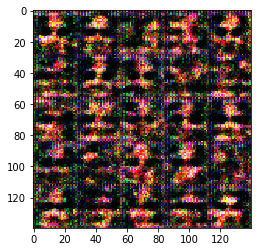

Iteration 5410 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5420 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5430 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5440 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5450 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5460 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5470 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5480 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5490 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5500 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


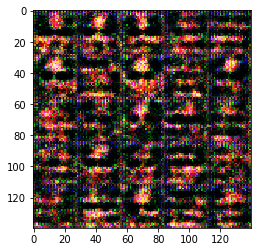

Iteration 5510 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5520 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5530 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5540 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5550 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5560 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5570 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5580 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5590 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5600 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


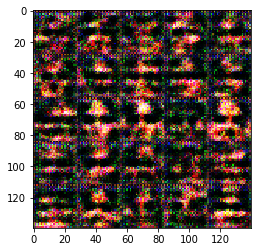

Iteration 5610 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5620 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5630 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5640 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5650 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5660 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5670 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5680 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5690 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5700 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


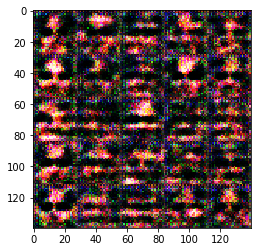

Iteration 5710 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5720 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5730 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5740 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5750 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5760 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5770 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5780 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5790 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5800 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


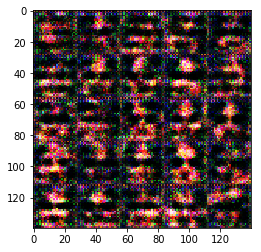

Iteration 5810 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5820 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5830 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5840 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5850 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5860 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5870 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5880 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5890 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5900 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


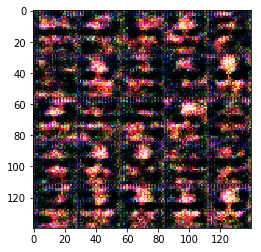

Iteration 5910 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 5920 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5930 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5940 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5950 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5960 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5970 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5980 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 5990 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 6000 -- Epoch 1/1 -- Discriminator loss: 1.10644 -- Generator loss: 0.69315


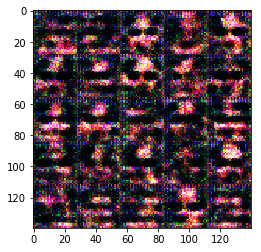

Iteration 6010 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6020 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 6030 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6040 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69315
Iteration 6050 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6060 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6070 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6080 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6090 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6100 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


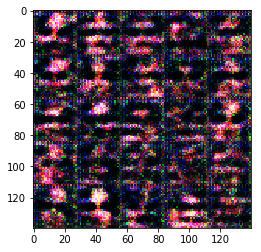

Iteration 6110 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6120 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6130 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6140 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6150 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6160 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6170 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6180 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69313
Iteration 6190 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6200 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314


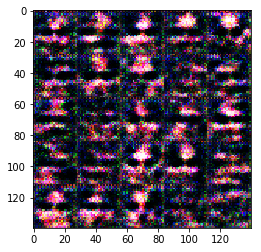

Iteration 6210 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6220 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6230 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6240 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 6250 -- Epoch 1/1 -- Discriminator loss: 1.10673 -- Generator loss: 0.69315
Iteration 6260 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6270 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 6280 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315
Iteration 6290 -- Epoch 1/1 -- Discriminator loss: 1.10642 -- Generator loss: 0.69314
Iteration 6300 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314


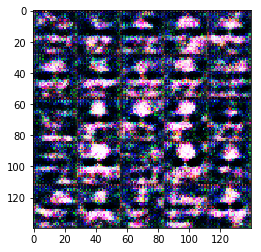

Iteration 6310 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69313
Iteration 6320 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69314
Iteration 6330 -- Epoch 1/1 -- Discriminator loss: 1.10641 -- Generator loss: 0.69315


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.